In [ ]:
!pip install numpy pillow opencv-python matplotlib tensorflow scikit-learn seaborn


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install tqdm


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
import numpy as np
import os
from PIL import Image, ImageOps, ImageFilter
import random
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16, VGG19, ResNet50, InceptionV3
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.models import load_model

In [10]:
# File paths for training and validation
img_train_path = r'D:\project work 2 phase 2\fingerprint\dataset_FVC2000_DB4_B\dataset\np_data\img_train.npy'
label_train_path = r'D:\project work 2 phase 2\fingerprint\dataset_FVC2000_DB4_B\dataset\np_data\label_train.npy'
train_data_folder = r'D:\project work 2 phase 2\fingerprint\dataset_FVC2000_DB4_B\dataset\train_data'

# File paths for testing
img_real_path = r'D:\project work 2 phase 2\fingerprint\dataset_FVC2000_DB4_B\dataset\np_data\img_real.npy'
label_real_path = r'D:\project work 2 phase 2\fingerprint\dataset_FVC2000_DB4_B\dataset\np_data\label_real.npy'
real_data_folder = r'D:\project work 2 phase 2\fingerprint\dataset_FVC2000_DB4_B\dataset\real_data'

In [11]:
# Function to load .npy file with error handling
def load_npy_file(file_path):
    try:
        data = np.load(file_path)
        print(f"Loaded: {file_path}")
        return data
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None

# Load .npy files
img_train = load_npy_file(img_train_path)
label_train = load_npy_file(label_train_path)
img_real = load_npy_file(img_real_path)
label_real = load_npy_file(label_real_path)

# Display shapes if data is loaded
if img_train is not None:
    print(f"Shape of img_train: {img_train.shape}")
if label_train is not None:
    print(f"Shape of label_train: {label_train.shape}")
if img_real is not None:
    print(f"Shape of img_real: {img_real.shape}")
if label_real is not None:
    print(f"Shape of label_real: {label_real.shape}")

Loaded: D:\project work 2 phase 2\fingerprint\dataset_FVC2000_DB4_B\dataset\np_data\img_train.npy
Loaded: D:\project work 2 phase 2\fingerprint\dataset_FVC2000_DB4_B\dataset\np_data\label_train.npy
Loaded: D:\project work 2 phase 2\fingerprint\dataset_FVC2000_DB4_B\dataset\np_data\img_real.npy
Loaded: D:\project work 2 phase 2\fingerprint\dataset_FVC2000_DB4_B\dataset\np_data\label_real.npy
Shape of img_train: (800, 160, 160, 1)
Shape of label_train: (800, 1)
Shape of img_real: (10, 160, 160, 1)
Shape of label_real: (10, 1)


Displaying up to 10 images from D:\project work 2 phase 2\fingerprint\dataset_FVC2000_DB4_B\dataset\train_data...


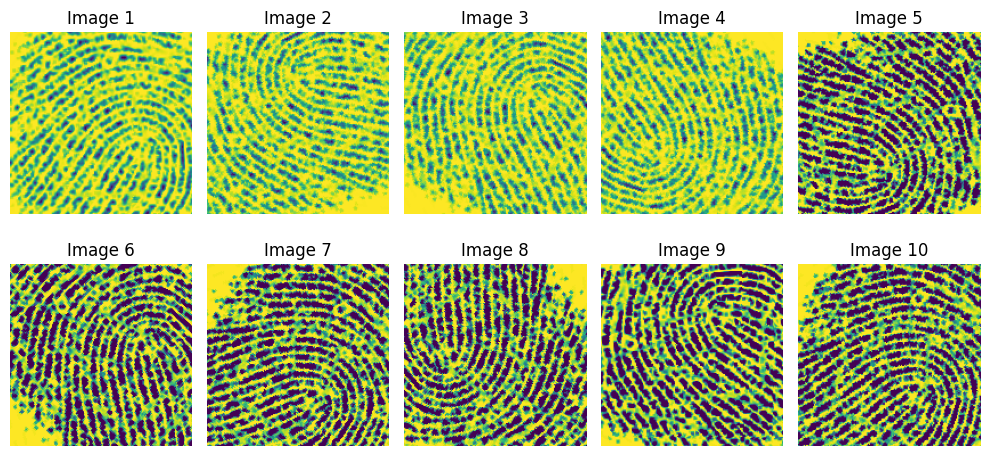

In [12]:
def display_images_from_folder(folder_path, num_images=10):
    if not os.path.exists(folder_path):
        print(f"Error: Folder not found at {folder_path}")
        return

    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'tiff'))]

    if len(image_files) == 0:
        print(f"No image files found in {folder_path}")
        return

    print(f"Displaying up to {num_images} images from {folder_path}...")
    plt.figure(figsize=(10, 5))
    for i, image_file in enumerate(image_files[:num_images]):
        image_path = os.path.join(folder_path, image_file)
        try:
            img = Image.open(image_path)
            plt.subplot(2, 5, i + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"Image {i + 1}")
        except Exception as e:
            print(f"Error loading image {image_file}: {e}")

    plt.tight_layout()
    plt.show()

display_images_from_folder(train_data_folder, num_images=10)

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
from PIL import Image
from tqdm import tqdm

# Define paths
data_folder = r'D:\project work 2 phase 2\fingerprint\dataset_FVC2000_DB4_B\dataset\train_data'
output_folder = r'D:\project work 2 phase 2\fingerprint\preprocessed_data'
os.makedirs(output_folder, exist_ok=True)

# Function to load images and extract metadata
def load_images_with_labels(folder_path):
    if not os.path.exists(folder_path):
        print(f"Error: Folder not found at {folder_path}")
        return pd.DataFrame()

    image_data = []
    labels = []
    image_files = sorted([f for f in os.listdir(folder_path) if f.lower().endswith('.bmp')])

    if len(image_files) == 0:
        print("No .bmp images found in the folder.")
        return pd.DataFrame()

    print(f"Found {len(image_files)} .bmp images. Processing...")

    for img_file in tqdm(image_files, desc="Loading Images"):
        img_path = os.path.join(folder_path, img_file)
        try:
            img = Image.open(img_path).convert('L')
            img_array = np.array(img)
            img_file_clean = img_file.replace('.bmp', '')
            parts = img_file_clean.split('_')
            if len(parts) < 2:  # Ensure both finger_index and user_id exist
                print(f"Skipping invalid file name format: {img_file}")
                continue
            finger_index = int(parts[0])
            user_id = int(parts[1])

            
            image_data.append(img_array)
            labels.append((finger_index, user_id))
        except Exception as e:
            print(f"Error loading image {img_file}: {e}")

    df = pd.DataFrame({'image': image_data, 'finger_index': [x[0] for x in labels], 'user_id': [x[1] for x in labels]})
    return df

# Function to preprocess images
def preprocess_image(image_path):
    img = Image.open(image_path).convert('L')
    img = img.resize((256, 256))
    img_np = np.array(img)
    img_np = cv2.GaussianBlur(img_np, (3, 3), 0)
    img_np = cv2.equalizeHist(img_np)
    return Image.fromarray(img_np)

# Function to preprocess dataset
def preprocess_dataset(folder_path, output_folder):
    if not os.path.exists(folder_path):
        print(f"Error: Folder not found at {folder_path}")
        return

    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.bmp', '.jpg', '.jpeg', '.png'))]
    
    if len(image_files) == 0:
        print("No images found in the folder.")
        return
    
    print(f"Processing {len(image_files)} images...")
    
    for img_file in tqdm(image_files, desc="Preprocessing Images"):
        img_path = os.path.join(folder_path, img_file)
        processed_img = preprocess_image(img_path)
        processed_img.save(os.path.join(output_folder, os.path.splitext(img_file)[0] + "_processed.png"))

    print("Preprocessing complete. Processed images saved.")

# Load images into DataFrame
image_df = load_images_with_labels(data_folder)

if not image_df.empty:
    print("\nSample Data (Index & User ID):\n")
    print(image_df[['finger_index', 'user_id']].head(10))
    image_df.to_pickle("fingerprint_dataset.pkl")
    print("\nDataset saved as 'fingerprint_dataset.pkl'.")

# Run preprocessing
preprocess_dataset(data_folder, output_folder)

Found 800 .bmp images. Processing...


Loading Images: 100%|██████████| 800/800 [00:08<00:00, 95.77it/s] 



Sample Data (Index & User ID):

   finger_index  user_id
0             0        0
1             0        1
2             0        2
3             0        3
4             0        4
5             0        5
6             0        6
7             0        7
8             0        8
9             0        9

Dataset saved as 'fingerprint_dataset.pkl'.
Processing 800 images...


Preprocessing Images: 100%|██████████| 800/800 [00:05<00:00, 137.05it/s]

Preprocessing complete. Processed images saved.


Total Inverted Images: 1600
Shape of inverted_images array: (1600, 256, 256)


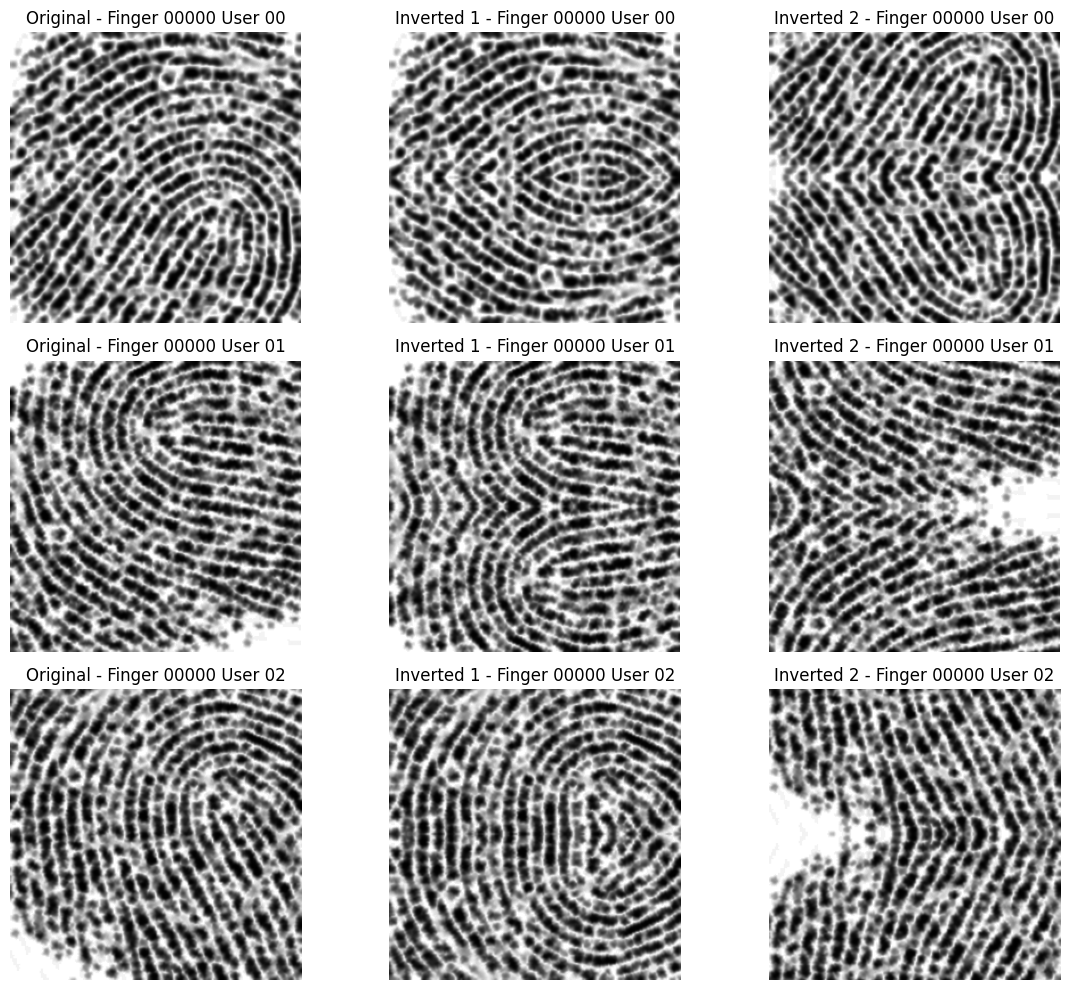

In [ ]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
from PIL import Image

# Load the preprocessed dataset
image_df = pd.read_pickle("fingerprint_dataset.pkl")

# Define input and output directories
preprocessed_dir = r"D:\project work 2 phase 2\fingerprint\preprocessed_data"
inverted_dir = r"D:\project work 2 phase 2\fingerprint\augmented_data\inverted"
os.makedirs(inverted_dir, exist_ok=True)

# Lists to store augmented images and labels
inverted_images = []
inverted_labels = []

# Function to apply inversion augmentation
def invert_image(image):
    h, w = image.shape  # Get height and width
    half_h = h // 2  # Split height in half

    # Split image into two halves
    top_half = image[:half_h, :]
    bottom_half = image[half_h:, :]

    # Flip halves vertically
    top_half_flipped = np.flipud(top_half)
    bottom_half_flipped = np.flipud(bottom_half)

    # Create two inverted images
    inverted_1 = np.vstack((top_half, top_half_flipped))
    inverted_2 = np.vstack((bottom_half, bottom_half_flipped))

    return inverted_1, inverted_2

# Apply inversion augmentation
for index, row in image_df.iterrows():
    finger_index = f"{row['finger_index']:05d}"
    user_id = f"{row['user_id']:02d}"

    processed_image_filename = f"{finger_index}_{user_id}_processed.png"
    processed_image_path = os.path.join(preprocessed_dir, processed_image_filename)

    if not os.path.exists(processed_image_path):
        print(f"File not found: {processed_image_path}")
        continue

    try:
        # Load and convert image
        original_image = np.array(Image.open(processed_image_path).convert('L'))
    except Exception as e:
        print(f"Error loading image {processed_image_path}: {e}")
        continue

    # Generate two inverted images
    inv_1, inv_2 = invert_image(original_image)

    # Store images and uniquely identified labels
    inverted_images.append(inv_1)
    inverted_labels.append((finger_index, user_id, 1))  # Unique ID 1 for first inversion

    inverted_images.append(inv_2)
    inverted_labels.append((finger_index, user_id, 2))  # Unique ID 2 for second inversion

# Check if images were generated
if len(inverted_images) == 0:
    print("No inverted images generated. Exiting.")
    exit()

# Convert to DataFrame
inverted_df = pd.DataFrame({
    "image": inverted_images,
    "finger_index": [x[0] for x in inverted_labels],
    "user_id": [x[1] for x in inverted_labels],
    "inversion_id": [x[2] for x in inverted_labels]
})

# Save the augmented dataset
inverted_df.to_pickle("inverted_fingerprint_dataset.pkl")

# Save inverted images with the corrected naming convention
with open(os.path.join(inverted_dir, 'inverted_labels.txt'), 'w') as label_file:
    for i, (image, (finger_index, user_id, inversion_id)) in enumerate(zip(inverted_images, inverted_labels)):
        image_name = f"{finger_index}_{user_id}_inversion_{inversion_id}.png"
        image_path = os.path.join(inverted_dir, image_name)
        Image.fromarray(image).save(image_path)
        label_file.write(f"{image_name}, {finger_index}, {user_id}, inversion, {inversion_id}\n")

# Display total count and shape of inverted images
print(f"Total Inverted Images: {len(inverted_images)}")
print(f"Shape of inverted_images array: {np.array(inverted_images).shape}")

# Display sample images (Original, Inverted_1, and Inverted_2)
num_samples = min(3, len(inverted_images) // 2)  # Ensure there are enough samples
fig, axes = plt.subplots(num_samples, 3, figsize=(12, 10))

for i in range(num_samples):
    finger_index = inverted_labels[2 * i][0]
    user_id = inverted_labels[2 * i][1]
    
    processed_image_filename = f"{finger_index}_{user_id}_processed.png"
    processed_image_path = os.path.join(preprocessed_dir, processed_image_filename)
    
    if not os.path.exists(processed_image_path):
        print(f"Skipping missing file: {processed_image_path}")
        continue

    try:
        original_image = np.array(Image.open(processed_image_path).convert('L'))
    except Exception as e:
        print(f"Error displaying image {processed_image_path}: {e}")
        continue

    inv_1 = inverted_images[2 * i]     # First inverted image
    inv_2 = inverted_images[2 * i + 1] # Second inverted image

    # Display original image
    axes[i, 0].imshow(original_image, cmap='gray')
    axes[i, 0].set_title(f"Original - Finger {finger_index} User {user_id}")
    axes[i, 0].axis('off')

    # Display inverted image 1
    axes[i, 1].imshow(inv_1, cmap='gray')
    axes[i, 1].set_title(f"Inverted 1 - Finger {finger_index} User {user_id}")
    axes[i, 1].axis('off')

    # Display inverted image 2
    axes[i, 2].imshow(inv_2, cmap='gray')
    axes[i, 2].set_title(f"Inverted 2 - Finger {finger_index} User {user_id}")
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

Preprocessing Images:   0%|          | 0/800 [00:00<?, ?it/s]

Preprocessing Images: 100%|██████████| 800/800 [00:06<00:00, 125.05it/s]


Preprocessing and multi-augmentation completed successfully.


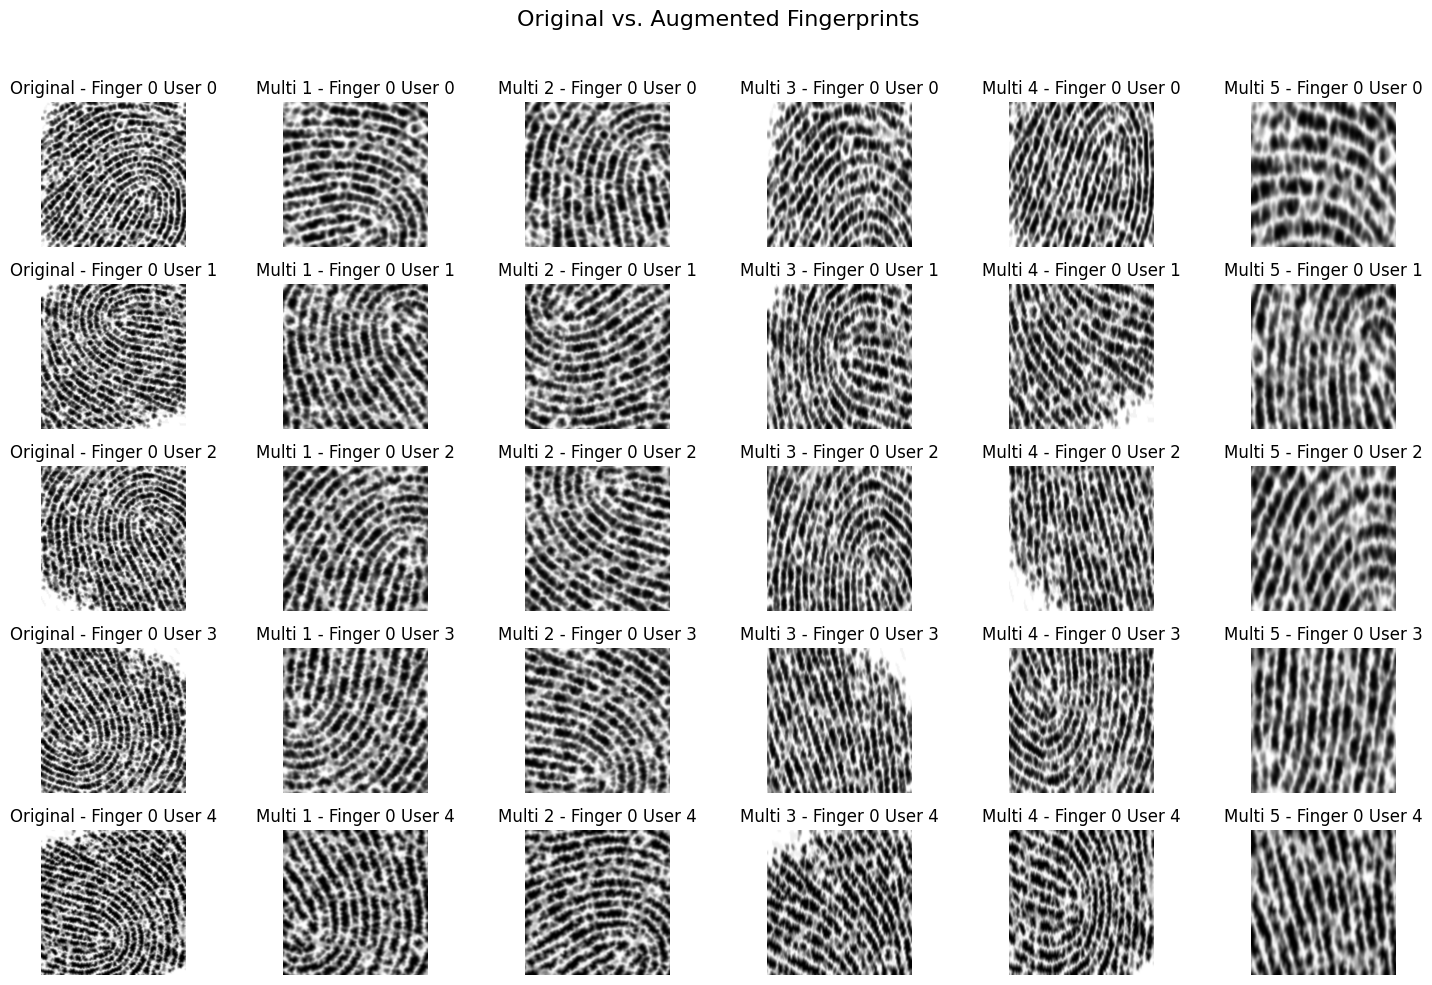

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
import pickle
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

# Define paths
data_folder = r'D:\project work 2 phase 2\fingerprint\dataset_FVC2000_DB4_B\dataset\train_data'
preprocessed_dir = r'D:\project work 2 phase 2\fingerprint\preprocessed_data'
augmented_dir = r'D:\project work 2 phase 2\fingerprint\augmented_data\multi_augmented'
os.makedirs(preprocessed_dir, exist_ok=True)
os.makedirs(augmented_dir, exist_ok=True)

# Function to preprocess images
def preprocess_image(image_path):
    img = Image.open(image_path).convert('L')
    img = img.resize((256, 256))
    img_np = np.array(img)
    img_np = cv2.GaussianBlur(img_np, (3, 3), 0)
    img_np = cv2.equalizeHist(img_np)
    return img_np

# Preprocess and save images
preprocessed_images = []
image_labels = []

image_files = [f for f in os.listdir(data_folder) if f.lower().endswith(('.bmp', '.jpg', '.jpeg', '.png'))]
for img_file in tqdm(image_files, desc="Preprocessing Images"):
    img_path = os.path.join(data_folder, img_file)
    processed_img = preprocess_image(img_path)
    processed_img_path = os.path.join(preprocessed_dir, os.path.splitext(img_file)[0] + "_processed.png")
    Image.fromarray(processed_img).save(processed_img_path)
    preprocessed_images.append(processed_img)
    
    parts = os.path.splitext(img_file)[0].split('_')
    if len(parts) >= 2:
        finger_index, user_id = int(parts[0]), int(parts[1])
        image_labels.append((finger_index, user_id))

# Function to apply multi-augmentation transformations
def apply_multi_augmentation(image):
    h, w = image.shape[:2]

    def rotate_and_crop(img, angle):
        matrix = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1)
        rotated = cv2.warpAffine(img, matrix, (w, h))
        crop_size = min(h, w) // 1.5
        crop_size = int(crop_size)
        x_start, y_start = (w - crop_size) // 2, (h - crop_size) // 2
        cropped = rotated[y_start:y_start + crop_size, x_start:x_start + crop_size]
        return cv2.resize(cropped, (w, h))

    left_rotated = rotate_and_crop(image, -45)
    right_rotated = rotate_and_crop(image, 45)
    half_h = h // 2
    top_half = cv2.resize(image[:half_h, :], (w, h))
    bottom_half = cv2.resize(image[half_h:, :], (w, h))
    left_top_half = cv2.resize(left_rotated[:half_h, :], (w, h))
    left_bottom_half = cv2.resize(left_rotated[half_h:, :], (w, h))
    right_top_half = cv2.resize(right_rotated[:half_h, :], (w, h))
    right_bottom_half = cv2.resize(right_rotated[half_h:, :], (w, h))

    return [left_rotated, right_rotated, top_half, bottom_half, left_top_half, left_bottom_half, right_top_half, right_bottom_half]

# Apply augmentation
multi_augmented_images = []
multi_augmented_labels = []
for image, (finger_index, user_id) in zip(preprocessed_images, image_labels):
    augmented_variants = apply_multi_augmentation(image)
    for i, img in enumerate(augmented_variants):
        multi_augmented_images.append(img)
        multi_augmented_labels.append((finger_index, user_id, i + 1))

# Save augmented images and labels
with open(os.path.join(augmented_dir, 'multi_augmented_labels.txt'), 'w') as label_file:
    for i, (image, (finger_index, user_id, aug_id)) in enumerate(zip(multi_augmented_images, multi_augmented_labels)):
        image_name = f"{finger_index}_{user_id}_multi_{aug_id}.png"
        image_path = os.path.join(augmented_dir, image_name)
        Image.fromarray(image).save(image_path)
        label_file.write(f"{image_name}, {finger_index}, {user_id}, multi, {aug_id}\n")

# Save as .pkl file
multi_augmented_df = pd.DataFrame({
    "image": multi_augmented_images,
    "finger_index": [x[0] for x in multi_augmented_labels],
    "user_id": [x[1] for x in multi_augmented_labels],
    "augmentation_id": [x[2] for x in multi_augmented_labels]
})
multi_augmented_df.to_pickle("multi_augmented_fingerprint_dataset.pkl")

print("Preprocessing and multi-augmentation completed successfully.")

# Display original and sample augmented images
num_samples = min(5, len(preprocessed_images))  # Display up to 5 samples
fig, axes = plt.subplots(num_samples, 6, figsize=(15, 10))
fig.suptitle("Original vs. Augmented Fingerprints", fontsize=16)

augmentation_labels = ["Multi 1", "Multi 2", "Multi 3", "Multi 4", "Multi 5"]

for i in range(num_samples):
    original_image = preprocessed_images[i]
    finger_index, user_id = image_labels[i]

    augmented_images = apply_multi_augmentation(original_image)

    # Show Original Image
    axes[i, 0].imshow(original_image, cmap="gray")
    axes[i, 0].set_title(f"Original - Finger {finger_index} User {user_id}")
    axes[i, 0].axis("off")

    # Show first 5 Augmented Images
    for j in range(5):
        axes[i, j + 1].imshow(augmented_images[j], cmap="gray")
        axes[i, j + 1].set_title(f"{augmentation_labels[j]} - Finger {finger_index} User {user_id}")
        axes[i, j + 1].axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [16]:
# # Display original and sample augmented images with proper naming
# num_samples = 5  # Number of images to display

# fig, axes = plt.subplots(num_samples, 6, figsize=(15, 10))
# fig.suptitle("Original vs. Augmented Fingerprints", fontsize=16)

# augmentation_labels = [
#     "Multi 1", "Multi 2", "Multi 3", "Multi 4", "Multi 5"
# ]  # First 5 augmentation labels

# for i in range(num_samples):
#     original_image = image_df.iloc[i]["image"]
#     finger_index = image_df.iloc[i]["finger_index"]
#     user_id = image_df.iloc[i]["user_id"]

#     augmented_images = apply_multi_augmentation(original_image)

#     # Show Original Image
#     axes[i, 0].imshow(original_image, cmap="gray")
#     axes[i, 0].set_title(f"Original - Finger {finger_index} User {user_id}")
#     axes[i, 0].axis("off")

#     # Show first 5 Augmented Images
#     for j in range(5):
#         axes[i, j + 1].imshow(augmented_images[j], cmap="gray")
#         axes[i, j + 1].set_title(f"{augmentation_labels[j]} - Finger {finger_index} User {user_id}")
#         axes[i, j + 1].axis("off")

# plt.tight_layout(rect=[0, 0, 1, 0.96])
# plt.show()

In [ ]:
import numpy as np
import pandas as pd

# Load original dataset
image_df = pd.read_pickle("fingerprint_dataset.pkl")

# Convert original images and labels to NumPy arrays
original_images = np.array(image_df["image"].tolist())
original_labels = np.array(list(zip(image_df["finger_index"], image_df["user_id"])))

# Load inverted dataset
inverted_df = pd.read_pickle("inverted_fingerprint_dataset.pkl")

# Convert inverted images and labels to NumPy arrays
inverted_images = np.array(inverted_df["image"].tolist())
inverted_labels = np.array(list(zip(inverted_df["finger_index"], inverted_df["user_id"])))

# Load multi-augmented dataset
multi_augmented_df = pd.read_pickle("multi_augmented_fingerprint_dataset.pkl")

# Convert multi-augmented images and labels to NumPy arrays
multi_augmented_images = np.array(multi_augmented_df["image"].tolist())
multi_augmented_labels = np.array(list(zip(multi_augmented_df["finger_index"], multi_augmented_df["user_id"])))

# Ensure inverted augmentation labels are structured correctly
inverted_augmented_images = np.array(inverted_images)
inverted_augmented_labels = np.array(inverted_labels).reshape(-1, 2)

# Display dataset shapes
print(f"Shape of original images: {original_images.shape}")  
print(f"Shape of original labels: {original_labels.shape}") 

print(f"Shape of inverted images: {inverted_images.shape}")  
print(f"Shape of inverted labels: {inverted_labels.shape}") 

print(f"Shape of multi-augmented images: {multi_augmented_images.shape}") 
print(f"Shape of multi-augmented labels: {multi_augmented_labels.shape}")  

print(f"Shape of inverted-augmented images: {inverted_augmented_images.shape}")  
print(f"Shape of inverted-augmented labels: {inverted_augmented_labels.shape}")  

Shape of original images: (800, 160, 160)
Shape of original labels: (800, 2)
Shape of inverted images: (1600, 256, 256)
Shape of inverted labels: (1600, 2)
Shape of multi-augmented images: (6400, 256, 256)
Shape of multi-augmented labels: (6400, 2)
Shape of inverted-augmented images: (1600, 256, 256)
Shape of inverted-augmented labels: (1600, 2)


In [ ]:
import os
import pandas as pd
from PIL import Image

# Define the base directory for saving the augmented data
base_dir = r'D:\project work 2 phase 2\fingerprint\augmented_data'
original_dir = os.path.join(base_dir, 'original')

# Create the directory for original images if it does not exist
os.makedirs(original_dir, exist_ok=True)

# Load the original dataset
image_df = pd.read_pickle("fingerprint_dataset.pkl")

# Save original images with the specified naming convention
with open(os.path.join(original_dir, 'original_labels.txt'), 'w') as label_file:
    for index, row in image_df.iterrows():
        original_image = row["image"]
        finger_index = row["finger_index"]
        user_id = row["user_id"]

        # Resize image to (256, 256)
        resized_image = Image.fromarray(original_image).resize((256, 256))

        # Construct the image name
        image_name = f"{finger_index}_{user_id}_original.png"
        image_path = os.path.join(original_dir, image_name)

        # Save the resized image
        resized_image.save(image_path)

        # Write the label to the text file
        label_file.write(f"{image_name}, {finger_index}, {user_id}, original\n")

print("Original images have been resized and saved successfully.")

Original images have been resized and saved successfully.


In [ ]:
import numpy as np
import pandas as pd
from PIL import Image

# Function to resize images
def resize_images(image_list, target_size=(256, 256)):
    return np.array([np.array(Image.fromarray(img).resize(target_size)) for img in image_list])

# Load original dataset
image_df = pd.read_pickle("fingerprint_dataset.pkl")
original_images = resize_images(image_df["image"].tolist(), target_size=(256, 256))
original_labels = np.array(list(zip(image_df["finger_index"], image_df["user_id"])))

# Load inverted dataset
inverted_df = pd.read_pickle("inverted_fingerprint_dataset.pkl")
inverted_images = resize_images(inverted_df["image"].tolist(), target_size=(256, 256))
inverted_labels = np.array(list(zip(inverted_df["finger_index"], inverted_df["user_id"])))

# Load multi-augmented dataset (inverted version)
multi_augmented_df = pd.read_pickle("multi_augmented_fingerprint_dataset.pkl")
multi_augmented_images = resize_images(multi_augmented_df["image"].tolist(), target_size=(256, 256))
multi_augmented_labels = np.array(list(zip(multi_augmented_df["finger_index"], multi_augmented_df["user_id"])))

# Ensure multi-augmented images and labels exist
if multi_augmented_images is not None and multi_augmented_labels is not None:
    inverted_multi_augmented_images = np.invert(multi_augmented_images)  # Apply inversion
    inverted_multi_augmented_labels = multi_augmented_labels.copy()  # Preserve labels

    print(f"Multi-Augmented Image Shape: {inverted_multi_augmented_images.shape}, Label Shape: {inverted_multi_augmented_labels.shape}")
else:
    inverted_multi_augmented_images, inverted_multi_augmented_labels = None, None
    print("Multi-Augmented images and labels not found!")

# Display dataset shapes
print(f"Original Image Shape: {original_images.shape}, Label Shape: {original_labels.shape}")
print(f"Inverted Image Shape: {inverted_images.shape}, Label Shape: {inverted_labels.shape}")

Multi-Augmented Image Shape: (6400, 256, 256), Label Shape: (6400, 2)
Original Image Shape: (800, 256, 256), Label Shape: (800, 2)
Inverted Image Shape: (1600, 256, 256), Label Shape: (1600, 2)
